# Know Your Data (KYD) — FPL Data Audit

**Purpose**: Understand what data exists, what each feature represents, and how it should (or should not) be used.

**Non-Goals**: No modeling, no feature engineering, no ranking, no decisions.

---

In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

# Paths
DB_PATH = "../storage/fpl_2025_26.sqlite"

# Connect
conn = sqlite3.connect(DB_PATH)

# List tables (exclude SQLite internal tables)
tables = pd.read_sql("SELECT name FROM sqlite_master WHERE type='table' AND name NOT LIKE 'sqlite_%'", conn)
print("Tables:", tables['name'].tolist())

Tables: ['players', 'teams', 'fixtures', 'gameweeks']


## 1. Data Inventory

| Table | Grain | Description | Known Pre/Post GW |
|-------|-------|-------------|-------------------|
| `players` | Player | Static player attributes (name, team, position, cost, status) | Pre (snapshot at pull time) |
| `gameweeks` | Player × GW | Per-gameweek performance outcomes (points, minutes, goals, etc.) | Post (only after GW completes) |
| `teams` | Team | Team metadata (name, strength ratings) | Pre (static per season) |
| `fixtures` | Fixture | Match schedule and results (home/away, goals, finished flag) | Pre (schedule) / Post (results) |

In [2]:
# Row counts per table
for table in ['players', 'gameweeks', 'teams', 'fixtures']:
    count = pd.read_sql(f"SELECT COUNT(*) as n FROM {table}", conn).iloc[0, 0]
    print(f"{table}: {count:,} rows")

players: 801 rows
gameweeks: 16,559 rows
teams: 20 rows
fixtures: 380 rows


## 2. Column Audit

### Semantic Type Definitions
- **state**: Current player/team attribute (cost, position, status)
- **outcome**: Result of a gameweek (points, goals, minutes)
- **market**: FPL game mechanics (ownership, transfers, selected_by)
- **metadata**: Identifiers and labels (id, name, code)

In [3]:
# Players table schema
players_schema = pd.read_sql("PRAGMA table_info(players)", conn)
print("PLAYERS TABLE")
print(players_schema[['name', 'type', 'notnull', 'dflt_value', 'pk']].to_string(index=False))

PLAYERS TABLE
                        name    type  notnull dflt_value  pk
                          id INTEGER        0       None   1
                  first_name    TEXT        0       None   0
                 second_name    TEXT        0       None   0
                    web_name    TEXT        0       None   0
                        team INTEGER        0       None   0
                element_type INTEGER        0       None   0
                    now_cost INTEGER        0       None   0
                      status    TEXT        0       None   0
chance_of_playing_next_round INTEGER        0       None   0
                total_points INTEGER        0       None   0
                        form    REAL        0       None   0
             points_per_game    REAL        0       None   0
         selected_by_percent    REAL        0       None   0
                   season_id INTEGER        0         10   0
                    modified    TEXT        0       None   0


### 2.1 Players Table

> **Note**: The players table is a **snapshot** at pull time. Some columns contain cumulative data that includes future GWs (leakage risk).

| column_name | data_type | semantic_type | description | available_pre_GW | notes / caveats |
|-------------|-----------|---------------|-------------|------------------|-----------------|
| `id` | INTEGER | metadata | Unique player ID | ✅ Yes | Primary key |
| `web_name` | TEXT | metadata | Display name (e.g., "Salah") | ✅ Yes | |
| `first_name` | TEXT | metadata | First name | ✅ Yes | |
| `second_name` | TEXT | metadata | Last name | ✅ Yes | |
| `team` | INTEGER | state | Team ID (FK to teams.id) | ✅ Yes | Can change mid-season (transfers) |
| `element_type` | INTEGER | state | Position (1=GK, 2=DEF, 3=MID, 4=FWD) | ✅ Yes | |
| `now_cost` | INTEGER | state | Current price in tenths (105 = £10.5m) | ✅ Yes | Changes based on transfers |
| `status` | TEXT | state | Availability (a=available, i=injured, s=suspended, u=unavailable) | ✅ Yes | **Updated live** — use cautiously |
| `chance_of_playing_next_round` | INTEGER | state | FPL's injury/availability flag (0-100 or NULL) | ✅ Yes | NULL = 100%; see note below |
| `total_points` | INTEGER | outcome | Season total points | ⚠️ LEAKAGE | Cumulative — includes future GWs at pull time |
| `selected_by_percent` | REAL | market | Ownership % | ✅ Yes | Reflects manager sentiment |
| `form` | REAL | outcome | Recent form (FPL's calculation) | ⚠️ Opaque | Unknown window; potential leakage — recompute |
| `points_per_game` | REAL | outcome | Average PPG | ⚠️ LEAKAGE | = total_points / appearances |

**Key Risk**: `total_points`, `points_per_game` in players table are **current snapshots** — they include information from gameweeks that may be in test set. `form` is opaque (unknown calculation window), so we avoid it and recompute from lagged gameweek data instead.

**On `chance_of_playing_next_round`**: This field represents FPL's manual assessment of short-term injury or availability risk and is only populated when a player is flagged. A NULL value implicitly indicates 100% availability. Because the signal is sparse, opaque in construction, and reactive to breaking news rather than predictive of systematic rotation or minutes management, we do not use it in modeling.

Instead, participation uncertainty is estimated empirically from lagged match data using rolling usage statistics (e.g., frequency of ≥60-minute appearances, minutes volatility, and sub-60 rates). These empirical estimators provide a consistent, data-driven measure of participation reliability across all players and align directly with decision-relevant thresholds in FPL scoring.

In [4]:
# Gameweeks table schema
gw_schema = pd.read_sql("PRAGMA table_info(gameweeks)", conn)
print("GAMEWEEKS TABLE")
print(gw_schema[['name', 'type', 'notnull', 'dflt_value', 'pk']].to_string(index=False))

GAMEWEEKS TABLE
                      name    type  notnull dflt_value  pk
                element_id INTEGER        0       None   0
                     round INTEGER        0       None   0
                   minutes INTEGER        0       None   0
              goals_scored INTEGER        0       None   0
                   assists INTEGER        0       None   0
              clean_sheets INTEGER        0       None   0
            goals_conceded INTEGER        0       None   0
                     bonus INTEGER        0       None   0
                       bps INTEGER        0       None   0
              total_points INTEGER        0       None   0
                 influence    REAL        0       None   0
                creativity    REAL        0       None   0
                    threat    REAL        0       None   0
                 ict_index    REAL        0       None   0
            expected_goals    REAL        0       None   0
          expected_assists    REAL      

### 2.2 Gameweeks Table

> **Note on "available_pre_GW"**: This column indicates whether the value is known **before that specific GW's deadline**. For prediction, you can use **lagged** values from prior GWs (e.g., use GW21's `ict_index` to predict GW22), but you cannot use GW22's `ict_index` before GW22 has been played.

| column_name | data_type | semantic_type | description | available_pre_GW | notes / caveats |
|-------------|-----------|---------------|-------------|------------------|-----------------|
| `element_id` | INTEGER | metadata | Player ID (FK to players.id) | ✅ Yes | Renamed from `element` for clarity |
| `round` | INTEGER | metadata | Gameweek number | ✅ Yes | |
| `total_points` | INTEGER | **outcome** | Points scored this GW | ❌ No | Target variable; use lagged for features |
| `minutes` | INTEGER | **outcome** | Minutes played | ❌ No | Participation signal; use lagged |
| `goals_scored` | INTEGER | outcome | Goals scored | ❌ No | Use lagged |
| `assists` | INTEGER | outcome | Assists | ❌ No | Use lagged |
| `clean_sheets` | INTEGER | outcome | Clean sheet (1/0) | ❌ No | Recorded for all; pts: GK/DEF +4, MID +1, FWD 0 |
| `goals_conceded` | INTEGER | outcome | Goals conceded | ❌ No | Recorded for all; pts: GK/DEF -1 per 2 goals |
| `saves` | INTEGER | outcome | Saves made | ❌ No | GK only in practice; +1 pt per 3 saves |
| `penalties_saved` | INTEGER | outcome | Penalties saved | ❌ No | GK only in practice; +5 pts |
| `bonus` | INTEGER | outcome | Bonus points (0-3) | ❌ No | Awarded post-match; use lagged |
| `bps` | INTEGER | outcome | Bonus point system score | ❌ No | Raw BPS before bonus allocation |
| `influence` | REAL | outcome | Influence index | ❌ No | FPL's proprietary metric; use lagged |
| `creativity` | REAL | outcome | Creativity index | ❌ No | Use lagged |
| `threat` | REAL | outcome | Threat index | ❌ No | Use lagged |
| `ict_index` | REAL | outcome | Combined ICT | ❌ No | = (I + C + T) / 10; use lagged |
| `expected_goals` | REAL | outcome | xG for this match | ❌ No | Post-match calculation; use lagged |
| `expected_assists` | REAL | outcome | xA for this match | ❌ No | Use lagged |
| `expected_goal_involvements` | REAL | outcome | xGI = xG + xA | ❌ No | Use lagged |
| `starts` | INTEGER | outcome | Started match (1/0) | ❌ No | Use lagged |
| `value` | INTEGER | state | Player value at that GW | ✅ Yes | Historical cost snapshot |
| `transfers_in` | INTEGER | market | Transfers in that GW | ❌ No | Post-deadline info |
| `transfers_out` | INTEGER | market | Transfers out that GW | ❌ No | Post-deadline info |
| `selected` | INTEGER | market | Times selected that GW | ✅ Yes | Pre-deadline snapshot |
| `team_id` | INTEGER | metadata | Team ID (FK to teams.id) | ✅ Yes | Normalized FK |
| `element_type` | INTEGER | metadata | Position code (1=GK, 2=DEF, 3=MID, 4=FWD) | ✅ Yes | Normalized FK |

**Key Insight**: Outcome columns (❌ No) become usable features when **lagged** — e.g., rolling average of `ict_index` from GW(n-5) to GW(n-1) to predict GW(n).

In [7]:
# Teams table schema
teams_schema = pd.read_sql("PRAGMA table_info(teams)", conn)
print("TEAMS TABLE")
print(teams_schema[['name', 'type']].to_string(index=False))

TEAMS TABLE
                 name    type
                   id INTEGER
                 name    TEXT
           short_name    TEXT
             strength INTEGER
strength_overall_home INTEGER
strength_overall_away INTEGER
 strength_attack_home INTEGER
 strength_attack_away INTEGER
strength_defence_home INTEGER
strength_defence_away INTEGER
            season_id INTEGER


### 2.3 Teams Table

> **Note**: Teams table is static per season. Strength ratings are updated by FPL periodically — values here are snapshots.

| column_name | data_type | semantic_type | description | available_pre_GW | notes |
|-------------|-----------|---------------|-------------|------------------|-------|
| `id` | INTEGER | metadata | Team ID | ✅ Yes | |
| `name` | TEXT | metadata | Full team name | ✅ Yes | |
| `short_name` | TEXT | metadata | 3-letter code | ✅ Yes | |
| `strength` | INTEGER | state | Overall strength (1-5) | ✅ Yes | FPL's rating |
| `strength_overall_home` | INTEGER | state | Home strength | ✅ Yes | |
| `strength_overall_away` | INTEGER | state | Away strength | ✅ Yes | |
| `strength_attack_home` | INTEGER | state | Home attack strength | ✅ Yes | |
| `strength_attack_away` | INTEGER | state | Away attack strength | ✅ Yes | |
| `strength_defence_home` | INTEGER | state | Home defence strength | ✅ Yes | |
| `strength_defence_away` | INTEGER | state | Away defence strength | ✅ Yes | |

**Key Insight**: All team attributes are safe to use — no outcome data here.

In [8]:
# Fixtures table schema
fixtures_schema = pd.read_sql("PRAGMA table_info(fixtures)", conn)
print("FIXTURES TABLE")
print(fixtures_schema[['name', 'type']].to_string(index=False))

FIXTURES TABLE
        name    type
          id INTEGER
       event INTEGER
      team_h INTEGER
      team_a INTEGER
team_h_score INTEGER
team_a_score INTEGER
kickoff_time    TEXT
    finished INTEGER
   season_id INTEGER


### 2.4 Fixtures Table

> **Note**: Contains all 380 fixtures (full season). Future fixtures have `finished=0` and NULL scores.

| column_name | data_type | semantic_type | description | available_pre_GW | notes |
|-------------|-----------|---------------|-------------|------------------|-------|
| `id` | INTEGER | metadata | Fixture ID | ✅ Yes | |
| `event` | INTEGER | metadata | Gameweek number | ✅ Yes | |
| `team_h` | INTEGER | state | Home team ID | ✅ Yes | |
| `team_a` | INTEGER | state | Away team ID | ✅ Yes | |
| `team_h_difficulty` | INTEGER | state | FDR for home team | ✅ Yes | Fixture difficulty rating |
| `team_a_difficulty` | INTEGER | state | FDR for away team | ✅ Yes | |
| `team_h_score` | INTEGER | **outcome** | Home team goals | ❌ No | Post-match; NULL for future fixtures |
| `team_a_score` | INTEGER | **outcome** | Away team goals | ❌ No | Post-match; NULL for future fixtures |
| `finished` | INTEGER | state | Match completed (1/0) | ✅ Yes | 0 for future, 1 after match |

**Key Insight**: Schedule (`team_h`, `team_a`, `event`, difficulty) is known pre-deadline. Scores are outcomes.

---

## 3. Feature Semantics (Narrative)

### 3.1 `minutes`
- **What it measures**: Time on pitch in a single match (0-90+)
- **What it does NOT measure**: Why a player didn't play (injury, rotation, tactical)
- **Common misinterpretation**: Treating 0 minutes as "bad performance" — it's absence, not performance
- **Correct future use**: Model participation probability separately from conditional performance

### 3.2 `total_points` (gameweeks table)
- **What it measures**: FPL points earned in a single GW
- **What it does NOT measure**: Underlying performance quality (a 1-pt appearance ≠ bad play)
- **Common misinterpretation**: Assuming points are normally distributed — they are heavily zero-inflated and right-skewed
- **Correct future use**: Target variable for regression; also threshold for haul classification (≥10)

### 3.3 `expected_goals` (xG)
- **What it measures**: Sum of goal probabilities from shots taken in that match
- **What it does NOT measure**: Shot quality beyond position (skill, keeper quality)
- **Common misinterpretation**: xG = goals. xG is probabilistic; variance is high per match
- **Correct future use**: Signal for attacking threat, smooth over 3-5 GWs

### 3.4 `expected_assists` (xA)
- **What it measures**: Probability that a pass leads to a goal (based on recipient's shot xG)
- **What it does NOT measure**: Pass quality beyond final ball
- **Common misinterpretation**: High xA = playmaker. Can be inflated by one big chance created
- **Correct future use**: Combined with xG as xGI for attacking involvement

### 3.5 ICT Index (`influence`, `creativity`, `threat`)
- **What it measures**: FPL's proprietary decomposition of match performance
- **What it does NOT measure**: Actual FPL points (correlation is imperfect)
- **Common misinterpretation**: High ICT = high points. ICT doesn't include clean sheets, bonus allocation quirks
- **Correct future use**: Supplementary signal; do not over-weight vs actual outcomes

### 3.6 `bonus`
- **What it measures**: 0-3 bonus points awarded post-match based on BPS
- **What it does NOT measure**: Predictable performance (bonus allocation has tie-breakers, edge cases)
- **Common misinterpretation**: "This player always gets bonus" — bonus is match-context dependent
- **Correct future use**: Include in target, but don't try to predict bonus directly

### 3.7 `selected_by_percent`
- **What it measures**: % of FPL managers who own this player
- **What it does NOT measure**: Future performance (ownership lags form)
- **Common misinterpretation**: High ownership = good pick. Ownership reflects past, not future
- **Correct future use**: Not for prediction. Useful for differential analysis only

---

## 4. Distribution & Sanity Checks

In [9]:
# Load gameweeks data
gw_df = pd.read_sql("SELECT * FROM gameweeks", conn)
print(f"Gameweeks: {len(gw_df):,} rows")
print(f"\nMissingness:")
print(gw_df.isnull().sum()[gw_df.isnull().sum() > 0])

Gameweeks: 16,559 rows

Missingness:
Series([], dtype: int64)


In [10]:
# Zero inflation check
print("Zero Inflation:")
print(f"  minutes == 0: {(gw_df['minutes'] == 0).mean():.1%}")
print(f"  total_points == 0: {(gw_df['total_points'] == 0).mean():.1%}")
print(f"  goals_scored == 0: {(gw_df['goals_scored'] == 0).mean():.1%}")
print(f"  bonus == 0: {(gw_df['bonus'] == 0).mean():.1%}")

Zero Inflation:
  minutes == 0: 59.7%
  total_points == 0: 61.5%
  goals_scored == 0: 96.9%
  bonus == 0: 95.8%


In [11]:
# Value ranges
print("Value Ranges:")
for col in ['minutes', 'total_points', 'goals_scored', 'bonus', 'bps']:
    print(f"  {col}: [{gw_df[col].min()}, {gw_df[col].max()}] (mean={gw_df[col].mean():.2f})")

Value Ranges:
  minutes: [0, 90] (mean=26.17)
  total_points: [-3, 24] (mean=1.21)
  goals_scored: [0, 3] (mean=0.03)
  bonus: [0, 3] (mean=0.08)
  bps: [-23, 94] (mean=4.71)


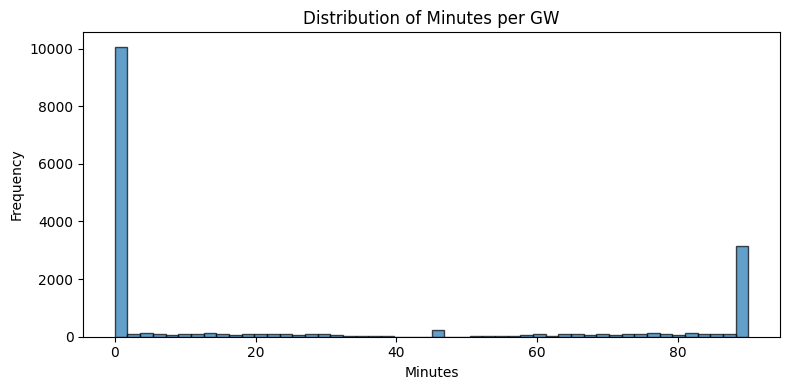

In [12]:
# Plot 1: Minutes distribution
fig, ax = plt.subplots(figsize=(8, 4))
ax.hist(gw_df['minutes'], bins=50, edgecolor='black', alpha=0.7)
ax.set_xlabel('Minutes')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Minutes per GW')
plt.tight_layout()
plt.show()

**Interpretation**: Heavy spike at 0 (non-participation) and 90 (full match). The bimodal structure confirms the two-stage framing: first model if they play, then model performance conditional on playing.

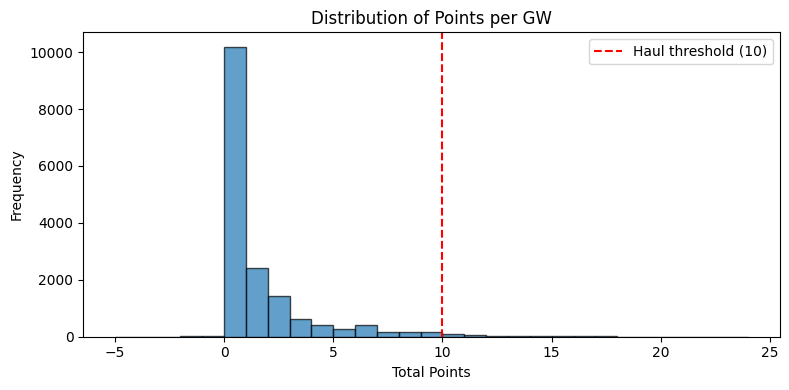

In [13]:
# Plot 2: Points distribution
fig, ax = plt.subplots(figsize=(8, 4))
ax.hist(gw_df['total_points'], bins=range(-5, 25), edgecolor='black', alpha=0.7)
ax.axvline(x=10, color='red', linestyle='--', label='Haul threshold (10)')
ax.set_xlabel('Total Points')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Points per GW')
ax.legend()
plt.tight_layout()
plt.show()

**Interpretation**: Right-skewed with mode at 2 points (appearance points). Long right tail confirms hauls (≥10) are rare events. Zero-inflation from non-participation.

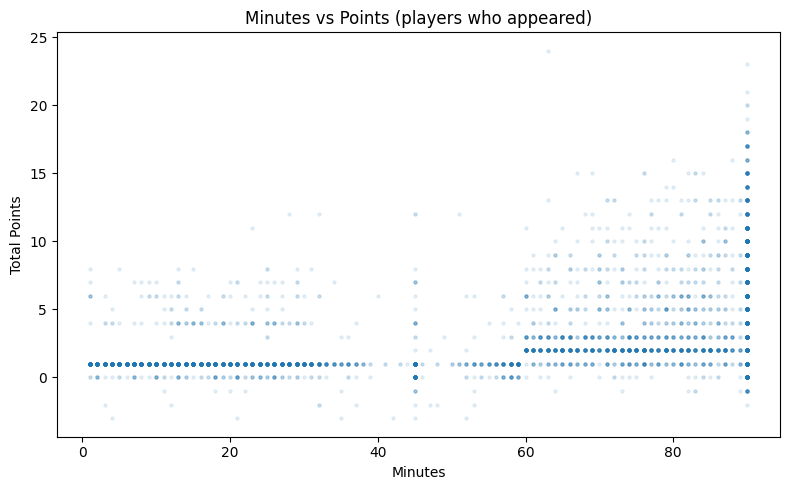

In [14]:
# Plot 3: Minutes vs Points (conditional on playing)
played = gw_df[gw_df['minutes'] > 0]
fig, ax = plt.subplots(figsize=(8, 5))
ax.scatter(played['minutes'], played['total_points'], alpha=0.1, s=5)
ax.set_xlabel('Minutes')
ax.set_ylabel('Total Points')
ax.set_title('Minutes vs Points (players who appeared)')
plt.tight_layout()
plt.show()

**Interpretation**: Positive relationship but high variance. 90-minute players have wider point range (more opportunity for returns). Sub-60 players cluster at low points.

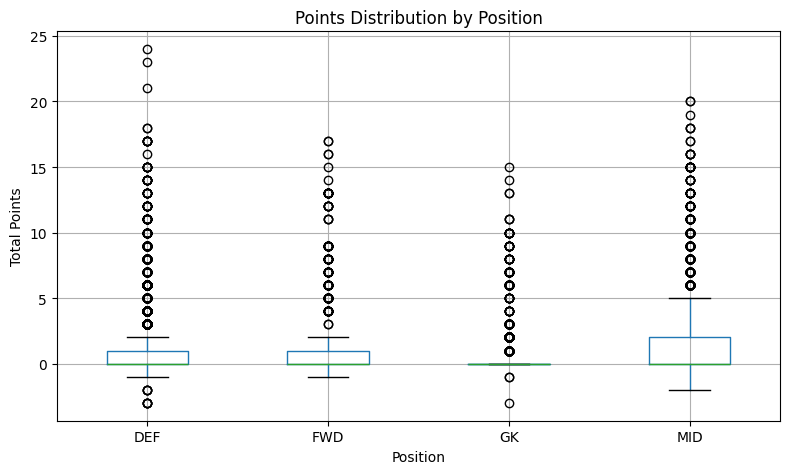

In [16]:
# Get position labels
players_df = pd.read_sql("SELECT id, element_type FROM players", conn)
gw_with_pos = gw_df.merge(players_df, left_on='element_id', right_on='id')
pos_map = {1: 'GK', 2: 'DEF', 3: 'MID', 4: 'FWD'}
gw_with_pos['position'] = gw_with_pos['element_type_y'].map(pos_map)

# Plot 4: Points by position
fig, ax = plt.subplots(figsize=(8, 5))
gw_with_pos.boxplot(column='total_points', by='position', ax=ax)
ax.set_xlabel('Position')
ax.set_ylabel('Total Points')
ax.set_title('Points Distribution by Position')
plt.suptitle('')  # Remove auto-title
plt.tight_layout()
plt.show()

**Interpretation**: Midfielders and Forwards have higher upside (longer whiskers). GKs and DEFs are more compressed — clean sheet points create discrete jumps rather than continuous variance.

---

## 5. Redundancy & Collinearity (Hypotheses)

The following pairs appear potentially redundant or highly correlated. These are **hypotheses to test later**, not conclusions.

| Feature Pair | Hypothesis |
|--------------|------------|
| `influence` + `creativity` + `threat` vs `ict_index` | ICT is a linear combination; keeping all 4 is redundant |
| `expected_goals` + `expected_assists` vs `expected_goal_involvements` | xGI = xG + xA; keeping all 3 is redundant |
| `starts` vs `minutes >= 60` | Near-identical signal; `starts` may have edge cases |
| `total_points` (players) vs sum of `total_points` (gameweeks) | Same data, different aggregation level |
| `selected_by_percent` vs `selected` | Same concept, different units |
| `form` vs rolling 5-GW points average | FPL's form is opaque; may duplicate engineered feature |

**Action**: Validate via correlation matrix or feature importance ablation in modeling phase.

---

## 6. Temporal Validity Check

| Feature | Known pre-deadline? | Lag required? | Safe for modeling? |
|---------|---------------------|---------------|--------------------|
| `now_cost` (players) | Yes | No | ✅ Yes |
| `status` (players) | Yes | No | ✅ Yes (but volatile) |
| `element_type` (players) | Yes | No | ✅ Yes |
| `team` (players) | Yes | No | ✅ Yes |
| `total_points` (players) | ⚠️ Snapshot | N/A | ❌ No — leakage |
| `form` (players) | ⚠️ Snapshot | N/A | ❌ No — leakage |
| `points_per_game` (players) | ⚠️ Snapshot | N/A | ❌ No — leakage |
| `selected_by_percent` (players) | Yes | No | ⚠️ Conditional — market signal |
| `total_points` (gameweeks) | No | Yes (prior GWs only) | ✅ Yes if lagged |
| `minutes` (gameweeks) | No | Yes (prior GWs only) | ✅ Yes if lagged |
| `expected_goals` (gameweeks) | No | Yes (prior GWs only) | ✅ Yes if lagged |
| `bonus` (gameweeks) | No | Yes (prior GWs only) | ✅ Yes if lagged |
| `team_h`, `team_a` (fixtures) | Yes | No | ✅ Yes |
| `team_h_score`, `team_a_score` (fixtures) | No | N/A | ❌ No — outcome |
| Strength ratings (teams) | Yes | No | ✅ Yes |

**Key Rule**: Gameweek-level outcomes must be lagged. Player-level aggregates (`total_points`, `form`) should be avoided — recompute from lagged gameweek data instead.

---

## 7. Mapping to Instrumental Goals

No computation. Conceptual mapping only.

### 7.1 Participation / Availability Signals
- `status` — injury/suspension flag
- `minutes` (lagged) — recent playing time
- `starts` (lagged) — starting vs substitute pattern

### 7.2 Conditional Performance Signals
- `total_points` (lagged) — historical scoring
- `expected_goals`, `expected_assists` (lagged) — underlying chance creation
- `influence`, `creativity`, `threat` (lagged) — match involvement
- `bonus`, `bps` (lagged) — match dominance proxy

### 7.3 Contextual Signals
- `team_h`, `team_a` (fixtures) — home/away indicator
- `team_h_difficulty`, `team_a_difficulty` — fixture difficulty
- Opponent strength ratings — from teams table

### 7.4 Variance / Volatility Descriptors
- `minutes` std over rolling window — rotation risk
- `total_points` std over rolling window — consistency
- Haul rate (% of GWs with ≥10 pts) — upside frequency

---

## 8. What We Likely Don't Need (Tentative)

The following features are **tentatively** low-signal or misleading. This will be validated via ablation.

| Feature | Reason |
|---------|--------|
| `total_points` (players table) | Leakage risk; recompute from gameweeks |
| `form` (players table) | Opaque FPL calculation; recompute as rolling mean |
| `points_per_game` (players table) | Leakage; derived from total_points |
| `transfers_in`, `transfers_out` | Post-deadline; herd behavior, not predictive |
| `ict_index` | Redundant if using I, C, T separately |
| `expected_goal_involvements` | Redundant if using xG + xA separately |
| `code`, `photo`, `news` | Metadata; no predictive value |

**Caveat**: These are hypotheses. Some may prove useful in edge cases.

---

## 9. Summary: Data Readiness Assessment

### Strengths

1. **Granular player×GW history (single season)** — supports time-aware supervised learning with clear prediction cutoffs.

2. **Rich GW-level outcomes** — `total_points`, xG, xA, bonus/BPS, and ICT components provide multiple views of performance.

3. **Fixture context** — home/away and opponent information are available for all GWs.

4. **Participation data** — minutes history enables explicit modeling of appearance and 60+ minute thresholds.

### Key Risks

1. **Within-season snapshot leakage** — season-to-date fields in the players snapshot (e.g., `total_points`, `form`, `points_per_game`, aggregated ICT) reflect the state at data extraction time and must be excluded, lagged, or reconstructed to align with the prediction GW.

2. **Zero inflation in minutes** — a substantial share of player×GW rows have 0 minutes, motivating separate modeling of participation vs conditional performance.

3. **Heavy-tailed points distribution** — rare hauls dominate utility but are underweighted by standard regression losses.

4. **ICT opacity** — ICT metrics are proprietary composites and should be treated as noisy summary signals rather than interpretable causal features.

### Two-Stage Uncertainty Support

The dataset supports a two-stage framing even within a single season:

| Stage | Signals Available |
|-------|-------------------|
| **Participation** (mins > 0, mins ≥ 60) | lagged minutes history, lagged indicators for appearance and ≥60 mins |
| **Performance \| Participation** (points, haul) | lagged GW outcomes (`total_points`), underlying GW signals (xG, xA, bonus/BPS, ICT), and fixture context |

### Conclusion

For a single-season setting, the primary technical risk is correct GW-level temporal alignment of snapshot features. With proper lagging, the data fully supports the participation vs conditional-performance decomposition.

In [18]:
# Cleanup
conn.close()